In [1]:
# !pip install -q tensorflow-recommenders
# !pip install -q --upgrade tensorflow-datasets
# !pip install -q scann

In [2]:
import os
import pprint
import tempfile
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import pandas as pd
import sampling
import pickle

import TensorflowBasicModel as tfrs_basic

# Constants 

## Load:

In [3]:
RATINGS_BASE = "../Data/base/ratings_base.parquet"
RECIPES_BASE = "../Data/base/recipes_base.parquet"

## Save:

In [4]:
MODEL1_CHECKPOINT_300 = '../Data/TFRS/basic/20_20/retrieval/model_1/300epochs/model1_retrieval_300_epochs_checkpoint'
MODEL1_HISOTRY_300 = '../Data/TFRS/basic/20_20/retrieval/model_1/300epochs/model1_history.obj'

MODEL1_CHECKPOINT_400 = '../Data/TFRS/basic/20_20/retrieval/model_1/400epochs/model1_retrieval_300_epochs_checkpoint'
MODEL1_HISOTRY_400 = '../Data/TFRS/basic/20_20/retrieval/model_1/400epochs/model1_history.obj'

TOP100_400EPOCHS_ACCURACY = '..Data//TFRS/basic/20_20/retrieval/model_1/400epochs/top100v400epochs.png'

# Load data 

In [5]:
recipes_data = pd.read_parquet(RECIPES_BASE)
ratings_data = pd.read_parquet(RATINGS_BASE)

## Prepare ratings sample

In [6]:
ratings_sample = sampling.get_ratings_with_min_number_list(ratings_data, [20,10])

## Prepare recipes sample

In [7]:
recipes_sample = recipes_data[recipes_data.RecipeId.isin(list(ratings_sample.RecipeId))].copy()

# Prepare dataset

## Ratings

For ranking task - only AuthorId - RecipeId pairs are used

In [8]:
ratings_sample.AuthorId = ratings_sample.AuthorId.map(lambda x: bytes(str(x), 'utf-8'))
ratings_sample.RecipeId = ratings_sample.RecipeId.map(lambda x: bytes(str(x), 'utf-8'))

In [9]:
ratings_dict = ratings_sample.groupby(['AuthorId', 'RecipeId'])['Rating'].sum().reset_index()

In [10]:
ratings_dict = {name: np.array(value) for name, value in ratings_dict.items()}
ratings = tf.data.Dataset.from_tensor_slices(ratings_dict)


In [11]:
ratings = ratings.map(lambda x: {'AuthorId' : x['AuthorId'], 
                                 'RecipeId' : x['RecipeId'],})

In [12]:
for x in ratings.take(10).as_numpy_iterator():
    pprint.pprint(x)

{'AuthorId': b'100149', 'RecipeId': b'10733'}
{'AuthorId': b'100149', 'RecipeId': b'116610'}
{'AuthorId': b'100149', 'RecipeId': b'12521'}
{'AuthorId': b'100149', 'RecipeId': b'125633'}
{'AuthorId': b'100149', 'RecipeId': b'127740'}
{'AuthorId': b'100149', 'RecipeId': b'16531'}
{'AuthorId': b'100149', 'RecipeId': b'19513'}
{'AuthorId': b'100149', 'RecipeId': b'21770'}
{'AuthorId': b'100149', 'RecipeId': b'24618'}
{'AuthorId': b'100149', 'RecipeId': b'25558'}


## Recipes

In [13]:
recipes_sample.RecipeId = recipes_sample.RecipeId.map(lambda x: bytes(str(x), 'utf-8'))
recipes_dict = recipes_sample[['RecipeId']]
recipes_dict = {name: np.array(value) for name, value in recipes_dict.items()}
recipes = tf.data.Dataset.from_tensor_slices(recipes_dict)

In [14]:
recipes = recipes.map(lambda x: x['RecipeId'])

In [15]:
users = ratings.map(lambda x: x['AuthorId'])

## Create train, val, test datasets

In [16]:
size = ratings_sample.shape[0]
train_size = int(0.7 * size)
val_size = int(0.15 * size)
test_size = size - train_size - val_size

tf.random.set_seed(42)
shuffled = ratings.shuffle(size, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(train_size)
val = shuffled.take(train_size).take(val_size)
test = shuffled.take(train_size).take(val_size).take(test_size)

In [17]:
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Val size: {val_size}")      

Train size: 193591
Test size: 41485
Val size: 41483


In [18]:
recipe_ids = recipes.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["AuthorId"])

unique_recipe_ids = np.unique(np.concatenate(list(recipe_ids)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [19]:
# unique_user_ids = [bytes(str(x), 'utf-8') for x in unique_user_ids]

In [20]:
# unique_recipe_ids = [bytes(str(x), 'utf-8') for x in unique_recipe_ids]

# Train & test - 20/10

In [23]:
model_1 = tfrs_basic.RecipeRetrievalModel(unique_recipe_ids=unique_recipe_ids, 
                                          unique_user_ids=unique_user_ids, 
                                          embedding_dimension=32,
                                          recipes=recipes)
model_1.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [24]:
cached_train = train.shuffle(250_000).batch(8192).cache()
cached_test = test.batch(4096).cache()
cached_val = val.batch(4096).cache()

## Fit 300 epochs

In [1]:
%%time
model_1_history = model_1.fit(cached_train,
                              epochs=300, 
                              verbose=0,
                              validation_data=cached_val,
                              validation_freq=5)

### Save

In [40]:
# model_1.save_weights(MODEL1_CHECKPOINT_300)
# with open(MODEL1_HISOTRY_300, 'wb') as pickle_file:
#     pickle.dump(model_1_history.history, pickle_file)

### Plot

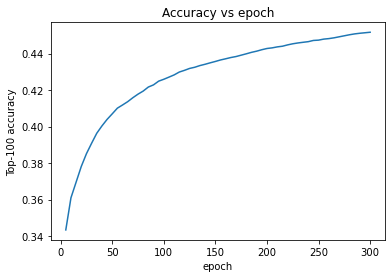

In [41]:
import matplotlib.pyplot as plt

num_validation_runs = len(model_1_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, model_1_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
# plt.legend()

### Test

In [45]:
evaluated_model_300epochs = model_1.evaluate(cached_test, return_dict=True)

12/12 [==============================] - 33s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0205 - factorized_top_k/top_5_categorical_accuracy: 0.1194 - factorized_top_k/top_10_categorical_accuracy: 0.1891 - factorized_top_k/top_50_categorical_accuracy: 0.3666 - factorized_top_k/top_100_categorical_accuracy: 0.4517 - loss: 21321.1762 - regularization_loss: 0.0000e+00 - total_loss: 21321.1762


In [50]:
print("Evaluated metrics:")
for metric in evaluated_model_300epochs.items():
    print(f"{metric[0]}: {metric[1]}")

Evaluated metrics:
factorized_top_k/top_1_categorical_accuracy: 0.020514804869890213
factorized_top_k/top_5_categorical_accuracy: 0.11939014494419098
factorized_top_k/top_10_categorical_accuracy: 0.18908457458019257
factorized_top_k/top_50_categorical_accuracy: 0.3666430115699768
factorized_top_k/top_100_categorical_accuracy: 0.4516697824001312
loss: 6967.71044921875
regularization_loss: 0
total_loss: 6967.71044921875


In [53]:
index = tfrs.layers.factorized_top_k.BruteForce(model_1.user_model)
index.index_from_dataset(tf.data.Dataset.zip((recipes.batch(100), recipes.batch(100).map(model_1.recipe_model))))

x, titles = index(tf.constant([b'2695']))

In [56]:
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'4807' b'57033' b'104604']
